In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np

import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

import keras
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

2025-04-29 17:36:54.439268: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745948214.659347      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745948214.723135      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
tf.random.set_seed(42)

In [3]:
ai_data = keras.utils.image_dataset_from_directory(
    "/kaggle/input/ai-generated-images-vs-real-images/AiArtData",
    image_size=(224, 224),
    batch_size=32,
    label_mode='int'  
)

real_data = keras.utils.image_dataset_from_directory(
    "/kaggle/input/ai-generated-images-vs-real-images/RealArt",
    image_size=(224, 224),
    batch_size=32,
    label_mode='int' 
)

norm_layer = tf.keras.layers.Rescaling(1./255)
norm_ai_data = ai_data.map(lambda x, y: (norm_layer(x), tf.ones_like(y)))  
norm_real_data = real_data.map(lambda x, y: (norm_layer(x), tf.zeros_like(y)))  
comb_data = norm_ai_data.concatenate(norm_real_data)

images_list = []
labels_list = []

for img, labels in comb_data:
    for image, label in zip(img, labels):
        images_list.append(image.numpy())
        labels_list.append(label.numpy())

img_array = np.asarray(images_list)
label_array = np.asarray(labels_list)

Found 536 files belonging to 1 classes.


I0000 00:00:1745948229.086986      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745948229.087732      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 435 files belonging to 1 classes.


In [4]:
x_train, x_temp, y_train, y_temp = train_test_split(img_array, label_array, test_size=0.4,random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5,random_state=42)

print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)
print("x_val:", x_val.shape)
print("y_val:", y_val.shape)

x_train: (582, 224, 224, 3)
y_train: (582,)
x_test: (194, 224, 224, 3)
y_test: (194,)
x_val: (195, 224, 224, 3)
y_val: (195,)


In [5]:
xception_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=xception_model.input, outputs=xception_model.get_layer('block14_sepconv2_act').output)

for layer in feature_extractor.layers:
    layer.trainable = False

x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('att_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(mode='min', monitor='val_loss', factor=0.1, patience=5, min_lr=0.00000001, verbose=1)

model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 111, 111, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 111, 111, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 109, 109, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 109, 109, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 109, 109, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 109, 109, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 109, 109, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 109, 109, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 55, 55, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 55, 55, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 22,960,681 (87.59 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [6]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=32,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20


I0000 00:00:1745948249.658483      66 service.cc:148] XLA service 0x7d21bc046000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745948249.659081      66 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745948249.659105      66 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745948250.546471      66 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/19 ━━━━━━━━━━━━━━━━━━━━ 4:22 15s/step - accuracy: 0.5000 - loss: 0.6848

I0000 00:00:1745948257.595369      66 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.5885 - loss: 0.7981
Epoch 1: val_accuracy improved from -inf to 0.75897, saving model to att_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 662ms/step - accuracy: 0.5913 - loss: 0.7928 - val_accuracy: 0.7590 - val_loss: 0.5190 - learning_rate: 0.0010
Epoch 2/20
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.8484 - loss: 0.3665
Epoch 2: val_accuracy improved from 0.75897 to 0.79487, saving model to att_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 187ms/step - accuracy: 0.8455 - loss: 0.3707 - val_accuracy: 0.7949 - val_loss: 0.4711 - learning_rate: 0.0010
Epoch 3/20
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.8807 - loss: 0.2955
Epoch 3: val_accuracy did not improve from 0.79487
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 0.8797 - loss: 0.2964 - val_accuracy: 0.7231 - val_loss: 0.4852 - learning_rate: 0.0010
Epoch 4/20
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9335 - loss: 0.1949
Epoch 4: val_accura

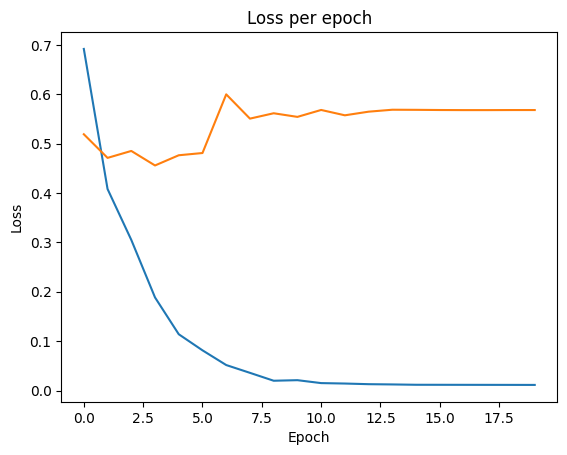

In [7]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

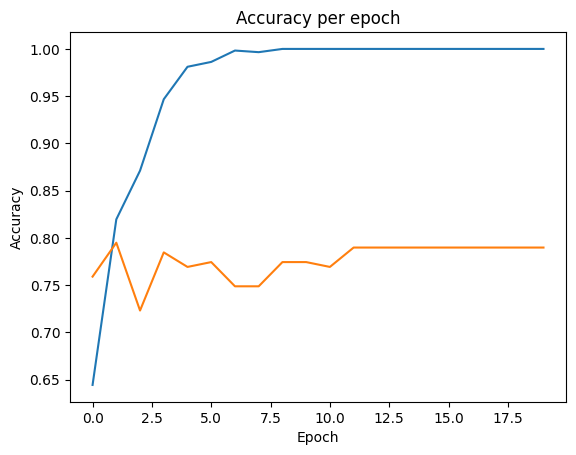

In [8]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()